In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import torch
torch.set_num_threads(1)

import colbert.warp.setup

from colbert.warp.config import WARPRunConfig
from colbert.warp.searcher import WARPSearcher
from colbert.warp.data.queries import WARPQueries

from colbert.warp.coreml_model import (
    XTRCoreMLConfig,
)

from colbert.utils.tracker import ExecutionTracker

scikit-learn version 1.4.1.post1 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.


#> Running WARP Setup Code.


In [2]:
optim = XTRCoreMLConfig()
config = WARPRunConfig(
    nranks=4,
    dataset="lotte",
    collection="writing",
    type_="search",
    datasplit="test",
    nbits=4,
    k=100,
    optim=optim
)
searcher = WARPSearcher(config)
queries = WARPQueries(config)

[Jul 18, 18:56:54] #> Loading collection...
0M 
#> Loading XTR CoreML model from '/Users/jlscheerer/xtr/models/coreml/xtr.mlpackage' (418.76MB)
[Jul 18, 18:56:57] #> Loading buckets...
[Jul 18, 18:56:57] #> Loading codec...
[Jul 18, 18:56:58] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jul 18, 18:57:04] #> Loading repacked residuals...
[Jul 18, 18:57:05] Loading precompute_topk_centroids_cpp extension (set WARP_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jul 18, 18:57:05] Loading decompress_centroid_embeds_strided_repacked_cpp extension (set WARP_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jul 18, 18:57:06] Loading compute_candidate_scores_cpp extension (set WARP_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jul 18, 18:57:06] #> Loading the queries from /Users/jlscheerer/future/datasets/writing/test/questions.search.tsv ...
[Jul 18, 18:57:06] #> Got 1071 queries. All QIDs are unique.



100%|███████████████████████████████████████| 1071/1071 [00:23<00:00, 46.15it/s]


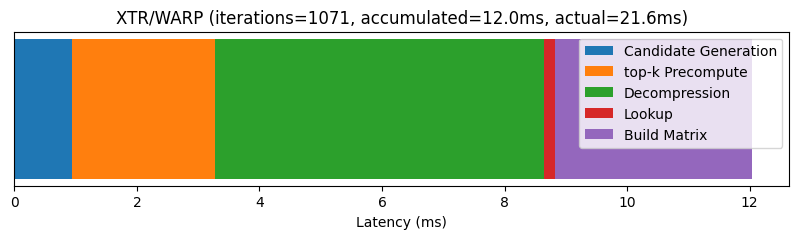

S@5: 76.7


In [4]:
tracker = ExecutionTracker(name="XTR/WARP", steps=["Query Encoding", "Candidate Generation", "top-k Precompute",
                                                   "Decompression", "Lookup", "Build Matrix"])
ranking = searcher.search_all(queries, k=5, batched=False, tracker=tracker)

tracker.display(["Candidate Generation", "top-k Precompute", "Decompression", "Lookup", "Build Matrix"])
print("S@5:", round(ranking.evaluate(queries.qrels, k=5)["metrics"]["Success@5"], 3) * 100)

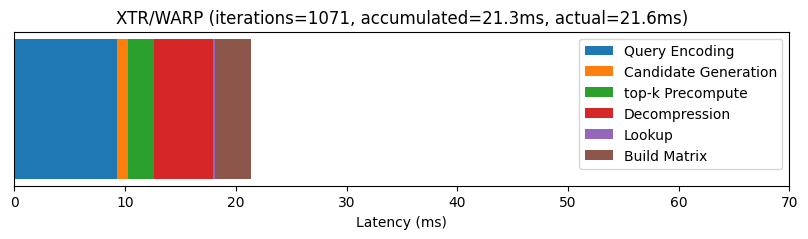

In [5]:
tracker.display(bound=70)

In [6]:
# TODO(jlscheerer) ColBERTv2/PLAID evaluation
# TODO(jlscheerer) This is not entirely clean because we should create an index dedicated to ColBERTv2/PLAID
from colbert.searcher import Searcher
from colbert.modeling.colbert import ColBERT
from tqdm import tqdm

ColBERT.try_load_torch_extensions(use_gpu=False)

cb_searcher = Searcher(index=config.index_name, config=config.colbert(), index_root=config.index_root, warp_engine=False)
cb_tracker = ExecutionTracker(name="ColBERTv2/PLAID", steps=["Query Encoding", "Candidate Generation", "Filtering", 
                                                             "Decompress Residuals", "Scoring", "Sorting"])

for qid, qtext in tqdm(queries):
    cb_tracker.next_iteration()
    cb_searcher.search(qtext, k=5, tracker=cb_tracker)
    cb_tracker.end_iteration()
# cb_tracker.display(["Candidate Generation", "Filtering", "Decompress Residuals", "Scoring", "Sorting"])

[Jul 11, 23:17:02] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jul 11, 23:17:02] #> Loading collection...
0M 
[Jul 11, 23:17:06] #> Loading codec...
[Jul 11, 23:17:06] #> Loading IVF...
[Jul 11, 23:17:06] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1155.93it/s]

[Jul 11, 23:17:06] #> Loading codes and residuals...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]

[Jul 11, 23:17:08] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Jul 11, 23:17:08] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1071/1071 [01:11<00:00, 15.01it/s]


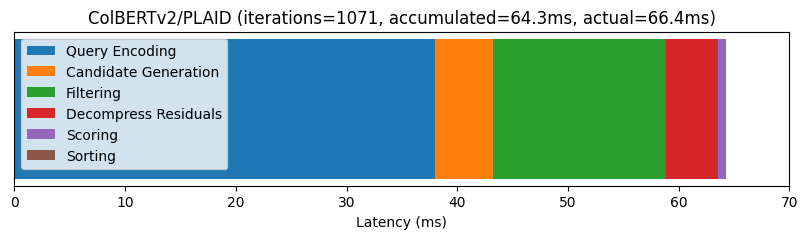

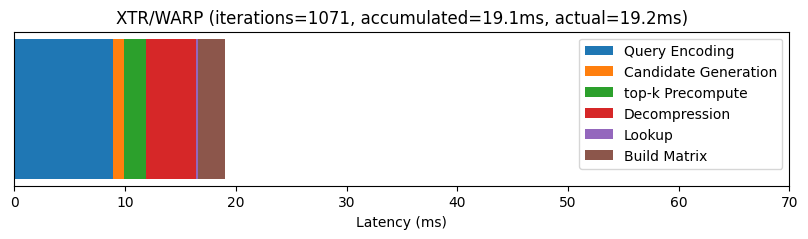

In [9]:
cb_tracker.display(bound=70)
tracker.display(bound=70)

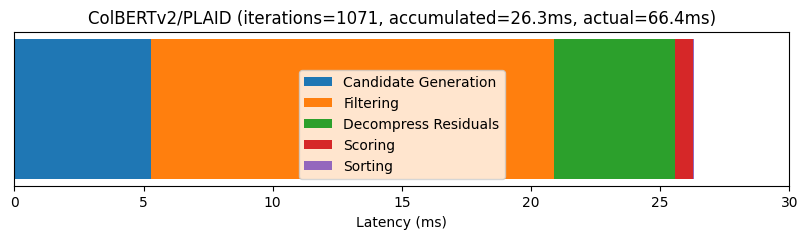

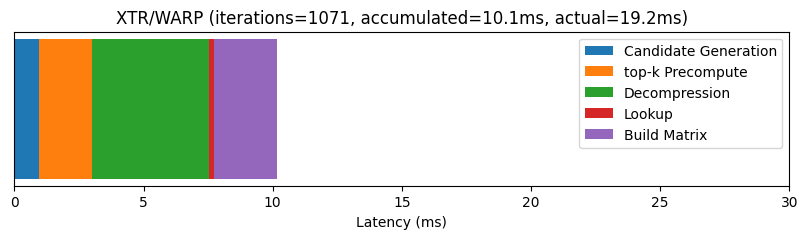

In [11]:
cb_tracker.display(["Candidate Generation", "Filtering", "Decompress Residuals", "Scoring", "Sorting"], bound=30)
tracker.display(["Candidate Generation", "top-k Precompute", "Decompression", "Lookup", "Build Matrix"], bound=30)